<a href="https://colab.research.google.com/github/shubhamwagh/nerf-toy/blob/main/notebook/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/shubhamwagh/nerf-toy.git

Cloning into 'nerf-toy'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 180 (delta 76), reused 111 (delta 43), pack-reused 9
Receiving objects: 100% (180/180), 1.39 MiB | 6.16 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [2]:
import sys
sys.path.append('/content/nerf-toy')

In [3]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.2 MB/s 


In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nerf_toy.data_loader import DataLoader
from nerf_toy.transforms import BasicEncodingTransform, PositionalEncodingTransform, GaussianFourierFeatureTransform
from nerf_toy.model import base_model
from nerf_toy.callback import PredictionVideoSaverCallback, PlotLossesAndMetricsCallback
from nerf_toy.metrics import PSNR, SSIM
from nerf_toy.utils import arr_to_image

In [6]:
img_url = "https://unsplash.com/photos/MMRd58Fo_Mk/download?force=true&w=640"
transform = GaussianFourierFeatureTransform(num_input_channels=2, mapping_size=128, scale=10)
loader = DataLoader(img_url, transform)

(1, 640, 640, 256)
(1, 640, 640, 3)


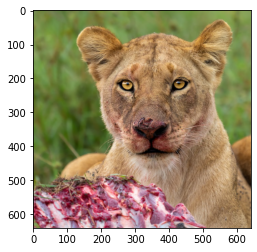

In [7]:
yx_grid, target = loader.load_data()
print(yx_grid.shape)
print(target.shape)

plt.imshow(target[0])
plt.show()

Epoch 1/300
1/1 - 10s - loss: 0.2659 - psnr: 9.8107 - ssim: 0.1095 - 10s/epoch - 10s/step
Epoch 2/300
1/1 - 1s - loss: 0.2617 - psnr: 9.9249 - ssim: 0.1107 - 545ms/epoch - 545ms/step
Epoch 3/300
1/1 - 1s - loss: 0.2576 - psnr: 10.0400 - ssim: 0.1119 - 571ms/epoch - 571ms/step
Epoch 4/300
1/1 - 1s - loss: 0.2535 - psnr: 10.1557 - ssim: 0.1132 - 588ms/epoch - 588ms/step
Epoch 5/300
1/1 - 1s - loss: 0.2494 - psnr: 10.2716 - ssim: 0.1145 - 572ms/epoch - 572ms/step
Epoch 6/300
1/1 - 1s - loss: 0.2455 - psnr: 10.3874 - ssim: 0.1158 - 630ms/epoch - 630ms/step
Epoch 7/300
1/1 - 1s - loss: 0.2416 - psnr: 10.5029 - ssim: 0.1172 - 559ms/epoch - 559ms/step
Epoch 8/300
1/1 - 1s - loss: 0.2379 - psnr: 10.6180 - ssim: 0.1186 - 567ms/epoch - 567ms/step
Epoch 9/300
1/1 - 1s - loss: 0.2342 - psnr: 10.7324 - ssim: 0.1200 - 575ms/epoch - 575ms/step
Epoch 10/300
1/1 - 1s - loss: 0.2306 - psnr: 10.8460 - ssim: 0.1215 - 559ms/epoch - 559ms/step
Epoch 11/300
1/1 - 1s - loss: 0.2271 - psnr: 10.9587 - ssim: 0.1

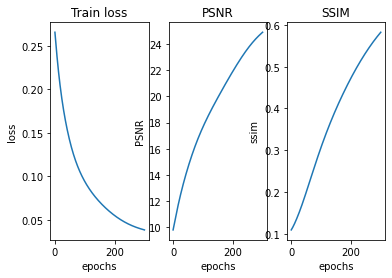

In [9]:
net = base_model(input_shape=yx_grid.shape[1:], output_dim=3, num_layers=4, num_channels=256)

loss = 'mae'
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
psnr_metric = PSNR(max_value=1.0)
ssim_metric = SSIM(max_value=1.0)

video_callback = PredictionVideoSaverCallback(yx_grid, target, every=1, video_path='/content')
plot_callback = PlotLossesAndMetricsCallback()

net.compile(optimizer=optimizer, loss=loss, metrics=[psnr_metric, ssim_metric])

hist = net.fit(x=yx_grid, y=target, epochs=300, verbose=2, callbacks=[video_callback, plot_callback])

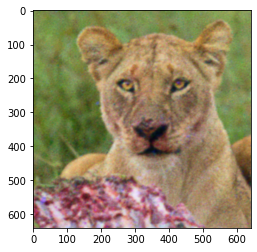

In [13]:
# Inference using trained model
generated = net(yx_grid, training=False)
plt.imshow(arr_to_image(generated[0]))
plt.show()

In [14]:
# Display video inline
file = video_callback.saved_path
from IPython.display import HTML
from base64 import b64encode
mp4 = open(file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=256 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>''')